###**Encoder - Decoder Model with Attention Mechanism**

###**Machine Translation**

In [1]:
# IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

tqdm.pandas()

In [3]:
# HYPERPARAMETERS (Updated)
BATCH_SIZE = 64
EMBEDDING_DIM = 64
UNITS = 128
NUM_EPOCHS = 50

In [4]:
# PREPROCESSING FUNCTION
def preprocess(sent, exclude, sp_tokens=False):
    sent = sent.lower()
    sent = re.sub("'", '', sent)
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.strip()
    sent = re.sub(" +", " ", sent)
    if sp_tokens:
        sent = '<start> ' + sent + ' <end>'
    return sent

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

def max_length(tensor):
    return max(len(t) for t in tensor)

# DATA LOADING FUNCTION
def data_loader(path, batch_size, samples=None, max_len=None, reverse=False):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    lines = [l.split('\t')[:-1] for l in lines]

    if samples:
        random.shuffle(lines)
        lines = lines[:samples]

    if reverse:
        lines = [l[::-1] for l in lines]

    exclude = set(string.punctuation)

    prep_lines = [
        [preprocess(i, exclude, sp_tokens=False),
         preprocess(j, exclude, sp_tokens=True)]
        for i, j in lines
    ]

    inp_lang = LanguageIndex(en for en, ma in prep_lines)
    tgt_lang = LanguageIndex(ma for en, ma in prep_lines)

    input_tensor = [[inp_lang.word2idx[w] for w in inp.split(' ')]
                    for inp, tgt in prep_lines]

    target_tensor = [[tgt_lang.word2idx[w] for w in tgt.split(' ')]
                     for inp, tgt in prep_lines]

    if max_len:
        new_input_tensor, new_target_tensor = [], []
        for i, j in zip(input_tensor, target_tensor):
            if (len(i) <= max_len) and (len(j) <= max_len):
                new_input_tensor.append(i)
                new_target_tensor.append(j)

        input_tensor, target_tensor = new_input_tensor, new_target_tensor
        max_length_inp = max_length_tgt = max_len
    else:
        max_length_inp, max_length_tgt = max_length(input_tensor), max_length(target_tensor)

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tgt, padding='post')

    (input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val) = train_test_split(
        input_tensor, target_tensor, test_size=0.1, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train)).batch(batch_size, drop_remainder=True)
    test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(len(input_tensor_val)).batch(batch_size, drop_remainder=True)

    return train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt


In [5]:
# LOAD DATASET
dataset_path = 'urd.txt'
train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader(dataset_path, BATCH_SIZE)

vocab_inp_size = len(inp_lang.word2idx)
vocab_tgt_size = len(tgt_lang.word2idx)

In [6]:
# We have two vocabularies one of english (vocab_inp_size) and the second is what you choose
# which is urdu in my case so it is vocab_tgt_size
print(vocab_inp_size )
print(vocab_tgt_size)

1334
1718


In [7]:
# Detokenize: tokens to string
def detokenize(tokens, idx2word):
    text = ""
    for t in tokens:
        if 'tensorflow' in str(type(tokens)):
            text += idx2word[t.numpy()] + ' '
        else:
            text += idx2word[t] + ' '
    text = text.replace(' <pad>', '')
    text = text.replace('<start>', '')
    text = text.replace('<end>', '')
    return text.strip()

In [8]:
eng, ur_target = next(iter(train_dataset))  # Unpack into two variables
ur_input = ur_target # Since we only have two values, we can assign ur_target to ur_input
print('Shape:', eng.shape, ur_input.shape, ur_target.shape)
print('English Sentence:', detokenize(eng[0], inp_lang.idx2word))
# Choose either ur_input or ur_target for detokenization
print('Urdu Sentence: ', detokenize(ur_input[0], tgt_lang.idx2word))  # Or ur_target[0]

Shape: (64, 18) (64, 23) (64, 23)
English Sentence: he always studies hard
Urdu Sentence:  وہ بہت محنت کے ساتھ پڑھتا ہے۔


## **Creating Model Architecure**
The encoder encode the English sentence and generates a `context_vector` which is used by decoder to decode the target phrase in urdu!

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embed_dim = embed_dim
        self.units = units
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)

    def call(self, x, mask=None):
        x = self.embedding(x)
        enc_output, state_h, state_c = self.rnn(x, mask=mask)
        return enc_output, state_h, state_c

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "units": self.units,
            "vocab_size": self.vocab_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [10]:
# Testing if Encoder works:
tmp_enc_outputs, tmp_enc_state_h, tmp_enc_state_c = Encoder(
    EMBEDDING_DIM, UNITS, vocab_inp_size
)(eng)

print(tmp_enc_outputs.shape, tmp_enc_state_h.shape, tmp_enc_state_c.shape)

(64, 18, 128) (64, 128) (64, 128)


### **Attention Mechanism**


![image.png](attachment:1b3641d9-f20d-49b7-b640-2d5fdc6f308a.png)

This is a rough sketch of how Attention Mechanism works.

In [12]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)

    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        score = self.W_v(tf.math.tanh(tf.expand_dims(query, 2) + tf.expand_dims(key, 1)))
        score = tf.squeeze(score, -1)

        if mask is not None:
            # Added indentation here
            score = tf.where(mask[:, :, :key.shape[1]], score, -1e6)


        attention_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attention_weights, value)
        return context, attention_weights

In [13]:
# DECODER
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embed_dim = embed_dim
        self.units = units
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
        self.attention = AdditiveAttention(units)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        dec_output, state_h, state_c = self.rnn(x, initial_state=state)
        state = (state_h, state_c)

        context_vector, attention_weights = self.attention(dec_output, enc_outputs, enc_outputs, mask)
        context_rnn_output = tf.concat([context_vector, dec_output], axis=-1)
        logits = self.fc(context_rnn_output)
        return logits, state, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "units": self.units,
            "vocab_size": self.vocab_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [14]:
# INSTANTIATE AND SAVE MODELS
encoder = Encoder(EMBEDDING_DIM, UNITS, vocab_inp_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, vocab_tgt_size)

In [15]:
# Custom loss function:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)
    return loss

In [16]:
# optimizer:
trainer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [17]:
# This will store loss function value at each epoch
# so we can plot it later
history = {
    'loss': []
}

In [18]:
for epoch in range(NUM_EPOCHS):
    total_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)

            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_state_h, enc_state_c = encoder(x)  # Unpack all three returned values
                dec_states = (enc_state_h, enc_state_c)

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs,
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)

                loss = loss/tf.reduce_sum(tgt_mask)

            variables = (encoder.trainable_variables +
            decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)

    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    print(f'Epoch: {epoch} | Loss: {epoch_loss}')

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'additive_attention' (of type AdditiveAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch: 0 | Loss: 6.5893749594688416


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | Loss: 5.630700409412384


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 | Loss: 5.035384088754654


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 | Loss: 4.853459060192108


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 | Loss: 4.7494427263736725


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 | Loss: 4.657347947359085


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 | Loss: 4.573770225048065


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 | Loss: 4.495398551225662


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 | Loss: 4.423672050237656


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 | Loss: 4.350168883800507


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Loss: 4.27738356590271


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 | Loss: 4.212361097335815


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 | Loss: 4.140029713511467


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 | Loss: 4.074677050113678


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 | Loss: 4.005023762583733


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 | Loss: 3.9418794959783554


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 | Loss: 3.8792851865291595


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 | Loss: 3.82317878305912


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 | Loss: 3.764538124203682


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 | Loss: 3.7010850608348846


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 | Loss: 3.6384101659059525


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 | Loss: 3.5780911594629288


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 | Loss: 3.5087313055992126


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 | Loss: 3.4390513598918915


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 | Loss: 3.370820716023445


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 | Loss: 3.2935076355934143


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 | Loss: 3.2331613898277283


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 | Loss: 3.16509947180748


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 | Loss: 3.0980925261974335


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 | Loss: 3.0226824581623077


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 | Loss: 2.9544850140810013


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 | Loss: 2.8823461681604385


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 | Loss: 2.8193532526493073


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 | Loss: 2.751130238175392


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 | Loss: 2.680952787399292


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 | Loss: 2.6121847927570343


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 | Loss: 2.547549679875374


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 | Loss: 2.475512459874153


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 | Loss: 2.4178260564804077


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 | Loss: 2.3548101037740707


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 | Loss: 2.286607012152672


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 | Loss: 2.2270192354917526


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 | Loss: 2.165679931640625


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 | Loss: 2.105822615325451


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 | Loss: 2.044455610215664


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 | Loss: 1.989375539124012


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 | Loss: 1.9325578138232231


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 | Loss: 1.8786350339651108


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 | Loss: 1.8288520351052284


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 | Loss: 1.7728550359606743


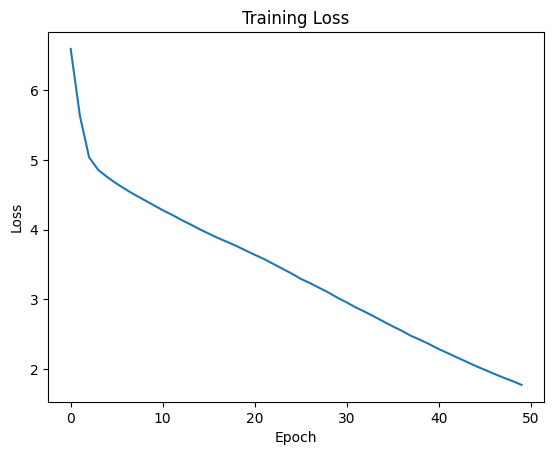

In [19]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
# Predict on new sentences:
def predict_seq2seq(encoder, decoder, src_tokens, tgt_vocab, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    # Modify this line to unpack all three returned values
    enc_outputs, enc_state_h, enc_state_c = encoder(enc_X, training=False)
    # Combine the hidden and cell states into a single state tuple
    dec_state = (enc_state_h, enc_state_c)

    dec_X = tf.expand_dims(tf.constant([tgt_vocab.word2idx['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tgt_vocab.word2idx['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))

    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tgt_vocab.idx2word), attention_weights

In [21]:
eng, ur = next(iter(train_dataset))
idx = -6
actual_seq = detokenize(ur[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'English Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

English Sentence:      dont make a mistake
Predicted Translation: مجھے دیکھو۔
Actual Translation:    کوئی غلطی نہ کرنا۔


In [22]:
# Save models
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")

In [24]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [25]:
import gradio as gr
import tensorflow as tf
import string

# Function to translate sentence based on selected language direction
def translate_sentence(text, direction):
    # Preprocess the input sentence
    exclude = set(string.punctuation)
    processed_sentence = preprocess(text, exclude, sp_tokens=False)

    # Convert to tokens
    if direction == "English → Urdu":
        input_tokens = [inp_lang.word2idx.get(word, 0) for word in processed_sentence.split()]
        input_tokens = tf.keras.preprocessing.sequence.pad_sequences([input_tokens], maxlen=max_length_inp, padding='post')
        translated_text, _ = predict_seq2seq(encoder, decoder, input_tokens[0], tgt_lang, max_length_tgt)
    else:  # Urdu → English
        input_tokens = [tgt_lang.word2idx.get(word, 0) for word in processed_sentence.split()]
        input_tokens = tf.keras.preprocessing.sequence.pad_sequences([input_tokens], maxlen=max_length_tgt, padding='post')
        translated_text, _ = predict_seq2seq(encoder, decoder, input_tokens[0], inp_lang, max_length_inp)

    return translated_text

# Create a better-styled Gradio Interface
iface = gr.Interface(
    fn=translate_sentence,
    inputs=[
        gr.Textbox(lines=3, placeholder="Enter text...", label="Input Text"),
        gr.Radio(["English → Urdu", "Urdu → English"], value="English → Urdu", label="Translation Direction")
    ],
    outputs=gr.Textbox(label="Translated Text"),
    title="🌍 AI-Powered Translator",
    description="🔠 Translate between **English** and **Urdu** instantly using AI. Select the direction and enter text!",
    examples=[
        ["Hello, how are you?", "English → Urdu"],
        ["تم کیسے ہو؟", "Urdu → English"],
        ["Where is the nearest restaurant?", "English → Urdu"],
        ["یہ کتاب کہاں ہے؟", "Urdu → English"]
    ],
    theme="compact",  # Apply a cleaner UI theme
    allow_flagging="never",  # Disable Gradio's default flagging system
    live=True  # Enables real-time translation as the user types
)

# Launch the Gradio app
iface.launch()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1102: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-67d5a9f9-4624087a2048198921a462a7;01215bdc-ad59-4ef8-b94b-a9ec4a7d8b4c)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")
/usr/local/lib/python3.11/dist-packages/gradio/interface.py:403: UserWarning

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://504d6ec30ef60685b4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
